# Local Cluster Dask Demo

_**Connect to a Local Dask Cluster on this machine and run analytics**_

This notebook works well with the `Python 3 (Data Science)` kernel on SageMaker Studio Notebook Instances with the `ml.t3.xlarge` instance (4 vCPU + 16GiB).

---

This notebook creates a local Dask cluster and then it reads the NYC taxi dataset from an S3 bucket and illustrates how to perform basic analytics tasks and machine learning tasks. 

1. Then the cluster is scaled up to demonstrate that the time taken for the analytics task decreases as the cluster scales up. 

1. A ML task is demonstrated on the same dataset using Dask-ML. 

**It is important to stick to the exact same version of the dependencies as installed in this notebook. Any changes to anything in this notebook or cloud formation scripts would most likely cause things to break and lead to a dependency hell.**

---

---

## Contents
1. [Tasks do be done in this lab](#Tasks-do-be-done-in-this-lab)
1. [Prepare the environment](#Prepare-the-environment)
1. [Connect to the Dask Cluster](#Connect-to-the-Dask-Cluster)
1. [Exploratory Data Analytics](#Exploratory-Data-Analytics)
1. [Scale out the cluster to see if the operations become faster](#Scale-out-the-cluster-to-see-if-the-operations-become-faster)
1. [Remove anomalies and plot the distribution](#Remove-anomalies-and-plot-the-distribution)
1. [Machine Learning with Dask](#Machine-Learning-with-Dask)

_**During the course of execution of this notebook you might see errors such as `distributed.nanny - WARNING - Worker process still alive after 3.9999988555908206 seconds, killing` these are OK, especially if the thing that you asked Dask to do did indeed complete, see more here [Why did my worker die?](https://distributed.dask.org/en/stable/killed.html).**_

---

## Tasks do be done in this lab

There are 4 tasks to be done in this lab. Look for `TASK 1`, `TASK 2`, `TASK 3` and `TASK 4` in this notebook for instructions for each of the tasks. You would need to write code for each of the task and save the output requested in a file as per the instructions provided for each task.

---

## Prepare the environment

Install the exact version of Python packages that work with the Dask cluster (based on the container used by the Dask cluster, see cloud formation templates).

In [2]:
!pip install dask[complete]==2022.2.0 s3fs==2022.7.1 pyarrow==9.0.0 dask-glm==0.2.0 cytoolz==0.12.0 dask-ml==2022.5.27

Install `htop` so that we can see the CPU and memory utilization because we would not be able to connect to the web portal of the local cluster (although there are ways of doing this but we would not be doing that in this class, see [ngrok](https://ngrok.com/))

In [3]:
!apt-get update
!apt-get install -y htop

Get:1 http://security.debian.org/debian-security buster/updates InRelease [34.8 kB]
Hit:2 http://deb.debian.org/debian buster InRelease       
Get:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Get:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [364 kB]
Fetched 455 kB in 0s (1030 kB/s)  
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
htop is already the newest version (2.2.0-1+b1).
0 upgraded, 0 newly installed, 0 to remove and 63 not upgraded.


In [4]:
import os
import dask
import s3fs
import time
import joblib
import distributed
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask.distributed import LocalCluster
from sklearn.metrics import mean_squared_error
from dask.distributed import performance_report
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split

---

## Connect to the Dask Cluster

With the right packages installed, now create and connect to the Dask cluster. Any Dask operations we do after that are automatically done at the _local_ cluster.

As created, the Dask cluster has one _scheduler task_ and as many _worker tasks_ as there are vCPUs on this instance.

In [5]:
# enable this client for fargate distributed cluster testing
cluster = LocalCluster()
client = Client(cluster)

In [6]:
client.cluster

Link to this cluster, we will not be able to access this, but if you run this notebook on your laptop you will be able to access it.

In [7]:
cluster.dashboard_link

'http://127.0.0.1:8787/status'

Use the `get_logs` function to access the logs of this cluster. Each task also has its web page.

In [8]:
cluster.get_logs()

{'Cluster': '',
 'Scheduler': "distributed.scheduler - INFO - Clear task state\ndistributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:34297\ndistributed.scheduler - INFO -   dashboard at:            127.0.0.1:8787\ndistributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:38689', name: 3, status: running, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:38689\ndistributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:45699', name: 0, status: running, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:45699\ndistributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:36073', name: 2, status: running, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:36073\ndistributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:43419', name: 1, status: running, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:43419\ndistributed.scheduler - INFO - Receive client connection: Client-61ec5724-40cc-11ed-9184-ebc71c949f13",
 'tcp://127.0.0.1:36073': 'distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:36073\ndistributed.worker - INFO -          Listening to:      tcp://127.0.0.1:36073\ndistributed.worker - INFO -          dashboard at:            127.0.0.1:42747\ndistributed.worker - INFO - Waiting to connect to:      tcp://127.0.0.1:34297\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -               Threads:                          1\ndistributed.worker - INFO -                Memory:                   3.87 GiB\ndistributed.worker - INFO -       Local Directory: /root/fall-2022-lab-05-lyhhhhhh1006/dask-worker-space/worker-1753lm0i\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -         Registered to:      tcp://127.0.0.1:34297\ndistributed.worker - INFO - -------------------------------------------------',
 'tcp://127.0.0.1:38689': 'distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:38689\ndistributed.worker - INFO -          Listening to:      tcp://127.0.0.1:38689\ndistributed.worker - INFO -          dashboard at:            127.0.0.1:43917\ndistributed.worker - INFO - Waiting to connect to:      tcp://127.0.0.1:34297\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -               Threads:                          1\ndistributed.worker - INFO -                Memory:                   3.87 GiB\ndistributed.worker - INFO -       Local Directory: /root/fall-2022-lab-05-lyhhhhhh1006/dask-worker-space/worker-8swbhtom\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -         Registered to:      tcp://127.0.0.1:34297\ndistributed.worker - INFO - -------------------------------------------------',
 'tcp://127.0.0.1:43419': 'distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:43419\ndistributed.worker - INFO -          Listening to:      tcp://127.0.0.1:43419\ndistributed.worker - INFO -          dashboard at:            127.0.0.1:45967\ndistributed.worker - INFO - Waiting to connect to:      tcp://127.0.0.1:34297\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -               Threads:                          1\ndistributed.worker - INFO -                Memory:                   3.87 GiB\ndistributed.worker - INFO -       Local Directory: /root/fall-2022-lab-05-lyhhhhhh1006/dask-worker-space/worker-c1jjw4k4\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -         Registered to:      tcp://127.0.0.1:34297\ndistributed.worker - INFO - ----

After initiating the scale up of cluster give it about 5 minutes for the additional compute to become available. Note the CPU and memory resources now available to the cluster.This cluster now has 6 works with 12 cores and 24GB RAM (recall we had 2 vCPUs and 4 GB per worker).

---

## Exploratory Data Analytics

We will be reading the new york taxi dataset for 2021 and running some analytics on it.

1. Note the similarity between the Dask dataframe API and the Pandas API.

1. Note that we are able to read all the files in one call using the `*` wildcard character.

Since this is a local cluster we will not be reading the entire year's worth of file, but just for one month.

### [TASK 1] Read the files for the last 3 months of the year

The demo in the class only read the file for December, for this task we need to read the files for the last **3 months** i.e. October, November and December. But first, **copy the files from `s3://bigdatateaching/nyctaxi-yellow-tripdata/csv/2021/` to your bucket using the following command.**

In [9]:
!aws s3 cp s3://bigdatateaching/nyctaxi-yellow-tripdata/csv/2021/ s3://anly502-fall-2022-yl1353/nyctaxi-yellow-tripdata/csv/2021 --recursive

copy: s3://bigdatateaching/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-02.csv to s3://anly502-fall-2022-yl1353/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-02.csv
copy: s3://bigdatateaching/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-04.csv to s3://anly502-fall-2022-yl1353/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-04.csv
copy: s3://bigdatateaching/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-01.csv to s3://anly502-fall-2022-yl1353/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-01.csv
copy: s3://bigdatateaching/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-03.csv to s3://anly502-fall-2022-yl1353/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-03.csv
copy: s3://bigdatateaching/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-05.csv to s3://anly502-fall-2022-yl1353/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-05.csv
copy: s3://bigdatateaching/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-06.csv to

In [10]:
# read the data directly from S3, data is accessible with anonymous credentials
months = "12" # REPLACE TODO with something to read the files of interest
df = dd.read_csv(f's3://anly502-fall-2022-yl1353/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-1*.csv',
                 parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])

The data frame is lazy loaded and is automatically partitioned (you can control this by specifying the `blocksize` parameter, see [read_csv](https://docs.dask.org/en/stable/generated/dask.dataframe.read_csv.html)).

In [11]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
npartitions=15,,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],float64,float64,float64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


How many rows did we read? Well, the `shape` attribute does not give us the number of rows because this dataframe is not yet been loaded into the memory only a DAG has been created for reading it. `shape` will tell us the number of columns, to get the number of rows we will have to do a `len`. The data contains about ~31 million rows.

In [12]:
df.shape

(Delayed('int-addcf255-147f-4a60-972d-2a508e9d898f'), 19)

In [13]:
%%time
print(f"{len(df):,}") 

10,150,822
CPU times: user 1.49 s, sys: 287 ms, total: 1.77 s
Wall time: 16.9 s


Let's find out average trip distance and total count.

In [14]:
%%time
start = time.perf_counter()
results = df[['trip_distance', 'total_amount']].mean().compute().to_frame().reset_index()
end = time.perf_counter()

# set column names for the resulting dataframe
results.columns = ["feature", "mean"]
results

CPU times: user 1.37 s, sys: 261 ms, total: 1.63 s
Wall time: 15.6 s


,feature,mean
0,trip_distance,7.251318
1,total_amount,20.606048


---


## Scale out the cluster to see if the operations become faster

It would make sense to say that if we double the size of the cluster then the time taken for the analytics task should reduce. Let us do that and see if it happens. We look at the cluster web portal to see that the number of tasks have increased.


In [15]:
cluster.scale(8)  # Sets the number of workers 

cluster.adapt(minimum=1, maximum=8)  # Allows the cluster to auto scale when tasks are computed

In [16]:
client.cluster

In [17]:
%%time
start = time.perf_counter()
results = df[['trip_distance', 'total_amount']].mean().compute().to_frame().reset_index()
end = time.perf_counter()

# set column names for the resulting dataframe
results.columns = ["feature", "mean"]
results

CPU times: user 2.58 s, sys: 476 ms, total: 3.05 s
Wall time: 18.3 s


,feature,mean
0,trip_distance,7.251318
1,total_amount,20.606048


**_As you can see, scaling out on the same instance does not help much because we were already at 100% CPU utilization on all the CPUs prior to scaling out. This is different from what we saw on a distributed cluster where scaling out truly made a difference._**

Here is a screenshot from htop about the memory and CPU utilization from all the tasks.



![](img/dask-ui-local-1.png)

#### Count the total trip distance and count for each vendor

In [18]:
%%time
df.groupby('VendorID').agg({'passenger_count':'count', 'trip_distance': 'sum'}).astype(int).compute()

CPU times: user 2.21 s, sys: 473 ms, total: 2.68 s
Wall time: 18.5 s


,passenger_count,trip_distance
VendorID,,
1,3031757,9641521
2,6752842,63795736
5,0,265
6,0,169316


### Selecting top 10 rides based on fare amount

In [19]:
%%time
most_paid_rides_dask = df[['PULocationID', 'fare_amount']].nlargest(10, "fare_amount").compute()

distributed.nanny - WARNING - Worker process still alive after 3.999998474121094 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.9999988555908206 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.9999990463256836 seconds, killing


CPU times: user 2.23 s, sys: 524 ms, total: 2.75 s
Wall time: 18.2 s


In [20]:
most_paid_rides_dask

,PULocationID,fare_amount
52279,143,3009.0
658476,183,1217.0
175824,132,1043.5
23475,265,1025.0
35739,265,984.0
35738,265,980.0
127785,265,950.0
255506,191,950.0
255507,191,950.0
404350,19,950.0


Clearly these represent anomalies in the data, a fare amount of hundereds of thousdands of dollars!!!!

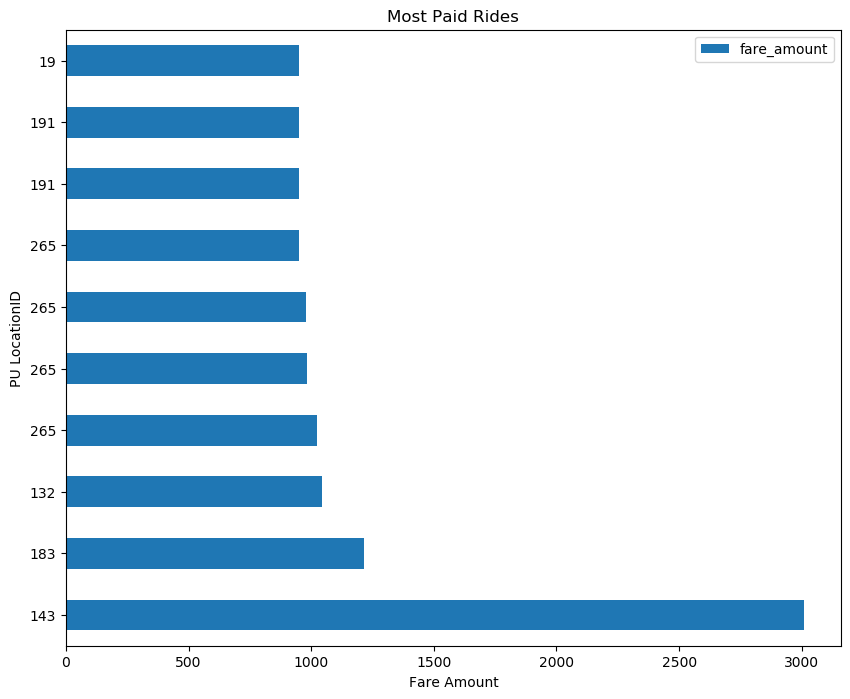

In [21]:
## Visualizing most paid rides through Barplot
most_paid_rides_dask.set_index('PULocationID').plot(kind='barh',stacked=False, figsize=[10,8], legend=True)

plt.title('Most Paid Rides')
plt.xlabel('Fare Amount')
plt.ylabel('PU LocationID')
plt.show()

#### Visualizing trip distance through Barplot

distributed.nanny - WARNING - Worker process still alive after 3.999998664855957 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.9999990463256836 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.9999988555908206 seconds, killing
tornado.application - ERROR - Exception in callback functools.partial(<function TCPServer._handle_connection.<locals>.<lambda> at 0x7fdcbba0c320>, <Task finished coro=<BaseTCPListener._handle_stream() done, defined at /opt/conda/lib/python3.7/site-packages/distributed/comm/tcp.py:530> exception=ValueError('invalid operation on non-started TCPListener')>)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tornado/ioloop.py", line 740, in _run_callback
    ret = callback()
  File "/opt/conda/lib/python3.7/site-packages/tornado/tcpserver.py", line 391, in <lambda>
    gen.convert_yielded(future), lambda f: f.result()
  File "/opt/conda/lib/python3.7/site-packages/dist

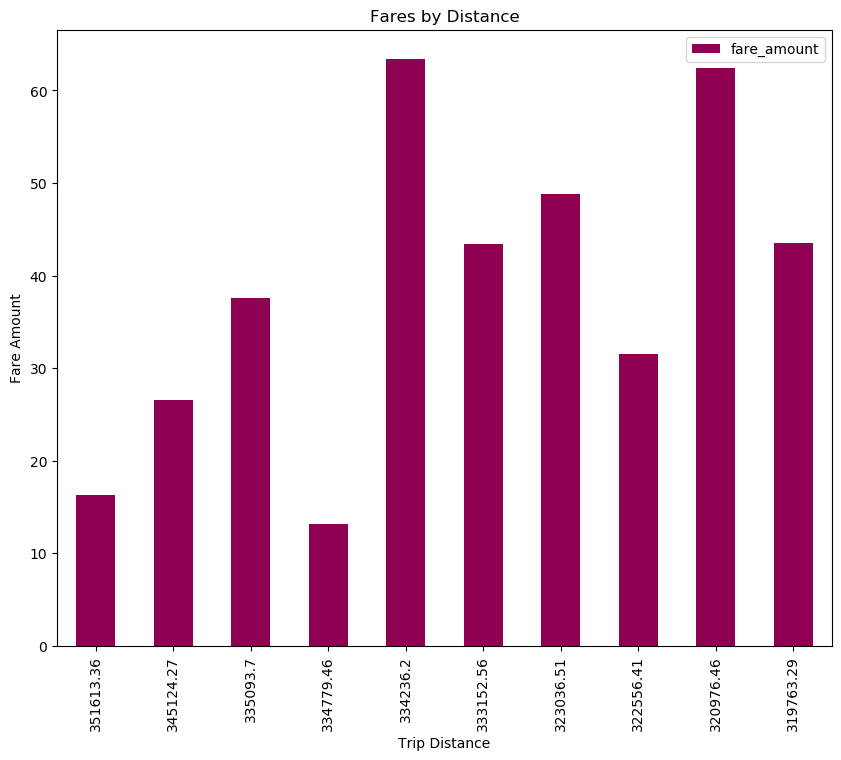

In [22]:
most_paid_rides_dask2 = df[['trip_distance', 'fare_amount']].nlargest(10, "trip_distance").compute()
most_paid_rides_dask2.set_index('trip_distance').plot(kind='bar', colormap='PiYG', stacked=False, figsize=[10,8], legend=True)

plt.title('Fares by Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

### Let's view the quantile distribution, something we should have done earlier

Clearly, anything about the 99th percentile as an anomaly.

We can save the complete details of what Dask did for running our code using the `performance_report` function, see [diagnosing performance](https://distributed.dask.org/en/stable/diagnosing-performance.html). See example below. 

**_If your task completes and you get the results then you can ignore exceptions from individual Dask tasks, Dask will take care of restarting any failed tasks for you._**

In [23]:
%%time
with performance_report(filename="dask-report-quantiles.html"):
    df_quantiles = df[['trip_distance', 'fare_amount']].quantile([0.25, 0.5, 0.75, 0.95, 0.99, 1]).compute().reset_index()
    print(df_quantiles)

distributed.nanny - WARNING - Worker process still alive after 3.999998664855957 seconds, killing


   index  trip_distance  fare_amount
0   0.25           1.18          7.5
1   0.50           2.06         11.5
2   0.75           4.20         18.0
3   0.95          16.77         52.0
4   0.99          20.78         65.0
5   1.00      351613.36       3009.0
CPU times: user 3.33 s, sys: 348 ms, total: 3.68 s
Wall time: 18 s


In [87]:
df99 = df_quantiles.loc[df_quantiles['index'] == 0.99]

In [88]:
df99.to_csv(r'q99.csv', sep='\t')

In [85]:
import csv

with open('q99.csv', 'w') as f: # output csv file
    writer = csv.writer(f)
    writer.writerow(df_quantiles.loc[df_quantiles['index'] == 0.99])

---

## [TASK 2] Remove anomalies and plot the distribution

We remove the anomalies from the `trip_distance` and `fare_amount` fields and plot their distributions using `matplotlib` as a histogram. 

1. To remove the anomalies we keep all values that are `>= 0` and `<= 99th percentile`.
1. The name of plot file for `fare_amount` should be `fare_amount.png`.
1. The name of plot file for `trip_distance` should be `trip_distance.png`.

In [24]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [25]:
df.trip_distance

Dask Series Structure:
npartitions=15
    float64
        ...
     ...   
        ...
        ...
Name: trip_distance, dtype: float64
Dask Name: getitem, 30 tasks

In [26]:
df.trip_distance = df.trip_distance[df.trip_distance >=0]
df.fare_amount = df.fare_amount[df.fare_amount >=0]
tripdis = df[["trip_distance","fare_amount"]][df.trip_distance <= df.trip_distance.quantile(.99)]
tripdis = tripdis[["trip_distance","fare_amount"]][df.fare_amount <= df.fare_amount.quantile(.99)]

In [27]:
tripdis

,trip_distance,fare_amount
npartitions=15,,
,float64,float64
,...,...
...,...,...
,...,...
,...,...


In [28]:
import matplotlib.pyplot as plt

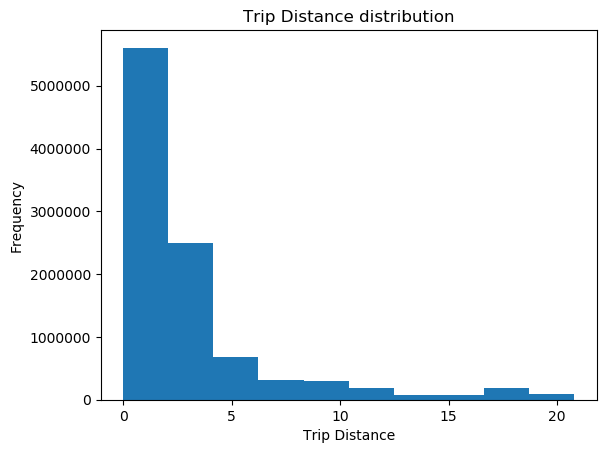

In [29]:
tripdis_dask = tripdis['trip_distance'].compute()

fig = plt.figure()
plt.hist(tripdis_dask)
plt.title('Trip Distance distribution')
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.show()

fig.savefig("trip_distance.png")

distributed.nanny - WARNING - Worker process still alive after 3.999998474121094 seconds, killing


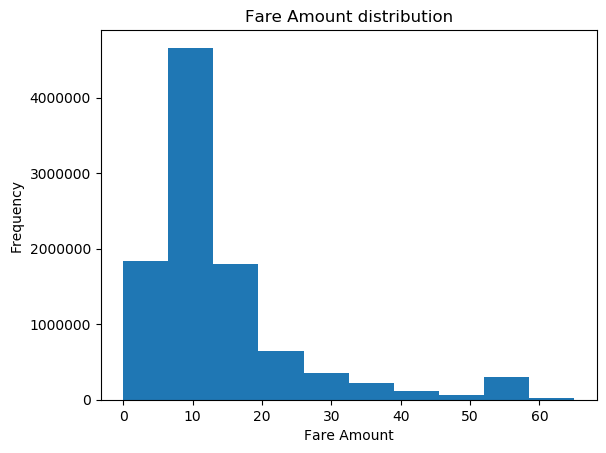

In [30]:
fareamo_dask = tripdis['fare_amount'].compute()

fig = plt.figure()
plt.hist(fareamo_dask)
plt.title('Fare Amount distribution')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

fig.savefig("fare_amount.png")

---

## Machine Learning with Dask

We create a derived field called `trip_duration` which is the difference between `tpep_dropoff_datetime` and `tpep_pickup_datetime` (note that both these fields were read as datetime when the Dask dataframe was initially created from the CSV files) and train a linear regression model to predict it based on `passenger_count`,`trip_distance`,`fare_amount` and `total_amount`. 

**_Note that the primary objective here is to show how a Dask cluster can be used to train an ML model rather than training the best model possible._**

In [31]:
# read the data directly from S3, data is accessible with anonymous credentials
df = dd.read_csv('s3://bigdatateaching/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-1*.csv',
                 storage_options={'anon': True},
                 parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])

In [32]:
df['trip_duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

In [33]:
df['trip_duration'].head()

0   0 days 00:45:39
1   0 days 00:24:18
2   0 days 00:22:45
3   0 days 00:39:02
4   0 days 00:22:36
Name: trip_duration, dtype: timedelta64[ns]

Convert the trip duration to hours.

In [34]:
df['trip_duration'] = df['trip_duration']/np.timedelta64(1,'D')
df['trip_duration'] = df['trip_duration'] * 24
df['trip_duration']

Dask Series Structure:
npartitions=15
    float64
        ...
     ...   
        ...
        ...
Name: trip_duration, dtype: float64
Dask Name: getitem, 180 tasks

In [35]:
df['trip_duration'].head()

distributed.nanny - WARNING - Worker process still alive after 3.999998474121094 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.9999988555908206 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.9999990463256836 seconds, killing


0    0.760833
1    0.405000
2    0.379167
3    0.650556
4    0.376667
Name: trip_duration, dtype: float64

In [36]:
%%time
df.head()

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 2.82 s


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2021-10-01 00:25:56,2021-10-01 01:11:35,1.0,7.40,1.0,Y,140,36,1,33.0,3.0,0.5,4.00,0.0,0.3,40.80,2.5,0.0,0.760833
1,1,2021-10-01 00:17:13,2021-10-01 00:41:31,1.0,14.10,1.0,N,209,94,2,39.0,3.0,0.5,0.00,0.0,0.3,42.80,2.5,0.0,0.405000
2,2,2021-10-01 00:25:22,2021-10-01 00:48:07,2.0,5.64,1.0,N,238,107,1,20.0,0.5,0.5,4.76,0.0,0.3,28.56,2.5,0.0,0.379167
3,1,2021-10-01 00:17:28,2021-10-01 00:56:30,0.0,5.50,1.0,N,48,179,1,27.5,3.0,0.5,3.00,0.0,0.3,34.30,2.5,0.0,0.650556
4,1,2021-10-01 00:09:30,2021-10-01 00:32:06,1.0,3.70,1.0,N,79,25,2,17.5,3.0,0.5,0.00,0.0,0.3,21.30,2.5,0.0,0.376667


Replace all NAs with 0

In [37]:
df = df.fillna(value=0)

In [38]:
df.shape

(Delayed('int-06d885c7-c463-418c-bf92-e0e5f6176a80'), 20)

In [39]:
len(df)

distributed.nanny - WARNING - Worker process still alive after 3.999998474121094 seconds, killing
tornado.application - ERROR - Exception in callback functools.partial(<function TCPServer._handle_connection.<locals>.<lambda> at 0x7fdc917f8560>, <Task finished coro=<BaseTCPListener._handle_stream() done, defined at /opt/conda/lib/python3.7/site-packages/distributed/comm/tcp.py:530> exception=ValueError('invalid operation on non-started TCPListener')>)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tornado/ioloop.py", line 740, in _run_callback
    ret = callback()
  File "/opt/conda/lib/python3.7/site-packages/tornado/tcpserver.py", line 391, in <lambda>
    gen.convert_yielded(future), lambda f: f.result()
  File "/opt/conda/lib/python3.7/site-packages/distributed/comm/tcp.py", line 536, in _handle_stream
    logger.debug("Incoming connection from %r to %r", address, self.contact_address)
  File "/opt/conda/lib/python3.7/site-packages/distributed/comm

10150822

**_The next would be to one-hot encode the categroical variables but we run into Dask related errors which so for now we will skip the categorical variables._**

Setup the features and the target variable and then do a train test split. We get the data we need as a pandas dataframe, this should not be needed we should be able to train with the lazy loaded dataframe. We run into errors with the tasks not finding `_sqrt` function, most likely because of using an older version of one of the packages. Updating the packages would mean using a newer container for the Dask scheduler and container, I tried that but that created other problems and for the purpose of this notebook I decided to stick to getting the data locally into this notebook and then relying on Dask to distribute it again, know that this is not how it will work in production.

In [40]:
#x = df[['VendorID','RatecodeID','PULocationID','DOLocationID','passenger_count','trip_distance','fare_amount','total_amount']]
x = df[['passenger_count','trip_distance','fare_amount','total_amount']].compute()

distributed.nanny - WARNING - Worker process still alive after 3.999998092651367 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.9999982833862306 seconds, killing


In [41]:
y = df['trip_duration'].compute()

distributed.nanny - WARNING - Worker process still alive after 3.999998664855957 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.999998664855957 seconds, killing


In [42]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

distributed.nanny - WARNING - Worker process still alive after 3.999998664855957 seconds, killing


In [43]:
len(X_train), len(X_test), len(y_train), len(y_test)

(9135739, 1015083, 9135739, 1015083)

The Dask API does not support dataframe so extract the array as `values`.

In [59]:
training_x = X_train.values
training_y = y_train.values

In [45]:
training_x

array([[ 1.  ,  1.74,  8.5 , 13.57],
       [ 1.  , 10.91, 31.5 , 56.03],
       [ 0.  ,  0.48, 11.45, 15.  ],
       ...,
       [ 3.  ,  2.74, 12.  , 18.2 ],
       [ 1.  ,  0.58,  6.5 , 12.96],
       [ 1.  ,  3.24, 17.  , 24.36]])

In [54]:
testing_x = X_test.values
testing_y = y_test.values

In [47]:
def rmse(preds, actuals):
    error = mean_squared_error(actuals, preds)
    rmse = np.sqrt(error)
    return rmse


## [TASK 3] Train the linear regression model on the Dask cluster.

Train the linear regression model and save the performance report in a file called `dask-report-lr.html`.

In [61]:
from dask_glm.datasets import make_regression

with performance_report(filename="dask-report-lr.html"): 
    #training_x, training_y = make_regression()
    lr = LinearRegression()
    lr.fit(training_x, training_y)

Prediction and RMSE.

In [62]:
preds = lr.predict(testing_x)
preds

array([0.22150827, 0.18413431, 0.24043522, ..., 0.28402319, 0.21525681,
       0.17173759])

In [63]:
testing_y

array([0.17027778, 0.09      , 0.15944444, ..., 0.33027778, 0.13472222,
       0.07722222])

In [64]:
rmse_val = rmse(preds, testing_y)
rmse_val

1.0547255641962696

### [Task 4] Save RMSE to a local file

The filename should be `rmse.txt`. the contents of the file should be (as an example) `rmse=3.456`.

In [65]:
with open('rmse.txt', 'w') as f:
    f.write('rmse = 1.055')